In [1]:
%%html
<!-- left align tables -->
<style>
table {margin-left: 0 !important;}
</style>

# Identify Persons of Interest in the Enron Corpus Dataset

## Introduction

....


## Data Exploration

### Dataset Description

.....

email
https://www.cs.cmu.edu/~./enron/

finance
http://news.findlaw.com/hdocs/docs/enron/enron61702insiderpay.pdf

In [2]:
# import packages
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from helper_functions import convert_dict_to_df, scatter_plot, print_score_table, best_parameter_search, find_best_parameters, print_score_parameter_table

In [3]:
# load dictionary containing the dataset
with open("enron_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# feature list
features = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 
            'director_fees', 'exercised_stock_options', 'expenses', 
            'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 
            'restricted_stock_deferred', 'salary', 'total_payments', 
            'total_stock_value', 'email_address', 'from_messages', 
            'from_poi_to_this_person', 'from_this_person_to_poi', 
            'shared_receipt_with_poi', 'to_messages']

# convert specified features to data frame
data_df = convert_dict_to_df(data_dict, features, remove_NaN=False, 
                        remove_all_zeroes=True, remove_any_zeroes=False, 
                        sort_keys=True)

print(data_df.shape)
print(len(list(data_df.columns.values)))
print(data_df['poi'].sum())

(146, 22)
22
18


The underlying dataset for this project is a combination of Enron email and financial data. The data is present in the `enron_dataset.pkl` file where it is stored in a dictionary structure. Each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. 

The data contains three major feature categories: POI labels, financial features and email features. The 21 feature names and their type are described in the table below.

| Feature                   | Type        |
|-------------------------- | ----------- |
| poi                       | categorical |
| bonus                     | numerical   |
| deferral_payments         | numerical   |
| deferred_income           | numerical   |
| director_fees             | numerical   |
| exercised_stock_options   | numerical   |
| expenses                  | numerical   |
| loan_advances             | numerical   |
| long_term_incentive       | numerical   |
| other                     | numerical   |
| restricted_stock          | numerical   |
| restricted_stock_deferred | numerical   |
| salary                    | numerical   |
| total_payments            | numerical   |
| total_stock_value         | numerical   |
| email_address             | text        |
| from_messages             | numerical   |
| from_poi_to_this_person   | numerical   |
| from_this_person_to_poi   | numerical   |
| shared_receipt_with_poi   | numerical   |
| to_messages               | numerical   |

The dataset contains information about 146 different data points. Of those, 18 are marked as POI.

Missing values...

In [4]:
# count number of NaN values in each column
print("Number of NaN values in each columns:")
print("-------------------------------------")
print(data_df.isnull().sum())

Number of NaN values in each columns:
-------------------------------------
name                           0
poi                            0
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
exercised_stock_options       44
expenses                      51
loan_advances                142
long_term_incentive           80
other                         53
restricted_stock              36
restricted_stock_deferred    128
salary                        51
total_payments                21
total_stock_value             20
email_address                 35
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
shared_receipt_with_poi       60
to_messages                   60
dtype: int64


The dataset contains a lot of features with missing values. One can see that it is based on the finacial data and that only for 86 point a connection to the email dataset could be made (60 data points without email data). For the features 'deferral_payments', 'director_fees', 'loan_advances' and 'restricted_stock_deferred' the fewest amount of  data is available.

### Outliers

In the financial data a strange outlier was found. This data point had the largest values for all the different financial feature and was identified as the 'TOTAL' column from the spreadsheet. Futhermore, I discovered the key 'THE TRAVEL AGENCY IN THE PARK' which is not the name of a person as well as the data point of 'LOCKHART EUGENE E' that consists of all zero values. These lines were dropped and not considered further.

In [5]:
# drop outlier rows
for n in ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']:
    data_df = data_df[data_df['name'] != n]

print(data_df.shape)

(143, 22)


log scaling of skewed distributions???

### Feature Engineering

Before selecting the features that influence 'poi' labelling the most I created two new features. First of all, I thought about looking at the ratio between 'restricted_stock' and 'total_stock_value'. As POIs in general had higher stock options maybe they also tried to prevent those from being restricted leading to low values for the 'poi_email_fraction'. Secondly, I created a new variable comparing the number of emails received from and sent to POIs with the total number of email received and sent by each pearson. I would expect POIs to communicate more frequently with other POIs and thus having higher 'poi_email_fraction' values.

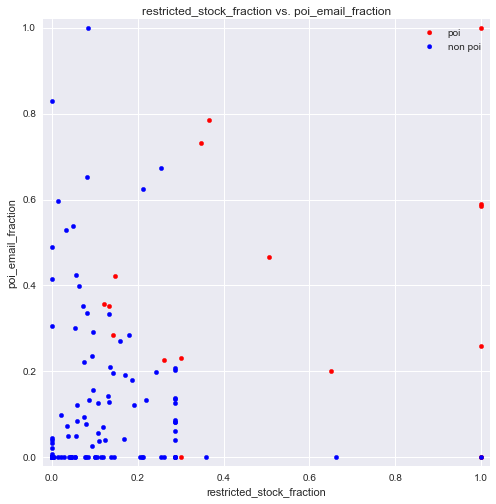

In [6]:
# poi fraction
data_df['restricted_stock_fraction'] = data_df['restricted_stock'] / data_df['total_stock_value']
data_df['poi_email_fraction'] = (data_df['from_poi_to_this_person'] + data_df['from_this_person_to_poi']) / (data_df['from_messages'] + data_df['to_messages'])

# visualization
scatter_plot(data_df, 'restricted_stock_fraction', 'poi_email_fraction')

By visualizing these new featuers one can see that all but one POI have a 'poi_email_fraction' larger than 0.2. The point that breaks ranks occurs as there is no email data for that person available. Most POIs have 'restricted_stock_fractions' between 0.2 and 0.7 but there are three data points that have all their stocks restricted.

### Feature Selection

To find the features who correlate the most with the `poi` label, I used the `SelectKBest()` method from the `sklearn` package. The results from this approach can be seen in the table below:

<font size="5" color="red">...expand on SelectKBest....</font>

In [7]:
X = data_df.fillna(value=0).select_dtypes(include=[np.number])
y = data_df['poi']

selector = SelectKBest(k=X.shape[1])
selector.fit(X, y)

features = X[selector.get_support(indices=True)].columns.values
scores = selector.scores_
score_list = sorted([(f, s) for f, s in zip(features, scores)], key=lambda tup: tup[1], reverse=True)

print("{:<25} {:<10}".format("Feature", "Score"))
print("-------------------------------")
for tup in score_list:
    print("{:<25} {}".format(tup[0], round(tup[1], 2)))

Feature                   Score     
-------------------------------
exercised_stock_options   24.82
total_stock_value         24.18
bonus                     20.79
salary                    18.29
deferred_income           11.46
long_term_incentive       9.92
restricted_stock          9.21
total_payments            8.77
shared_receipt_with_poi   8.59
loan_advances             7.18
expenses                  6.09
poi_email_fraction        5.4
from_poi_to_this_person   5.24
other                     4.19
from_this_person_to_poi   2.38
director_fees             2.13
to_messages               1.65
restricted_stock_fraction 1.09
deferral_payments         0.22
from_messages             0.17
restricted_stock_deferred 0.07


Nine of top ten features come from the financial data and only `shared_receipt_with_poi` comes from the emails. Before moving on, I also looked at these features in more detail by plotting them. An excerpt from that procedure can be found in the scatter matrix of the top five features below.

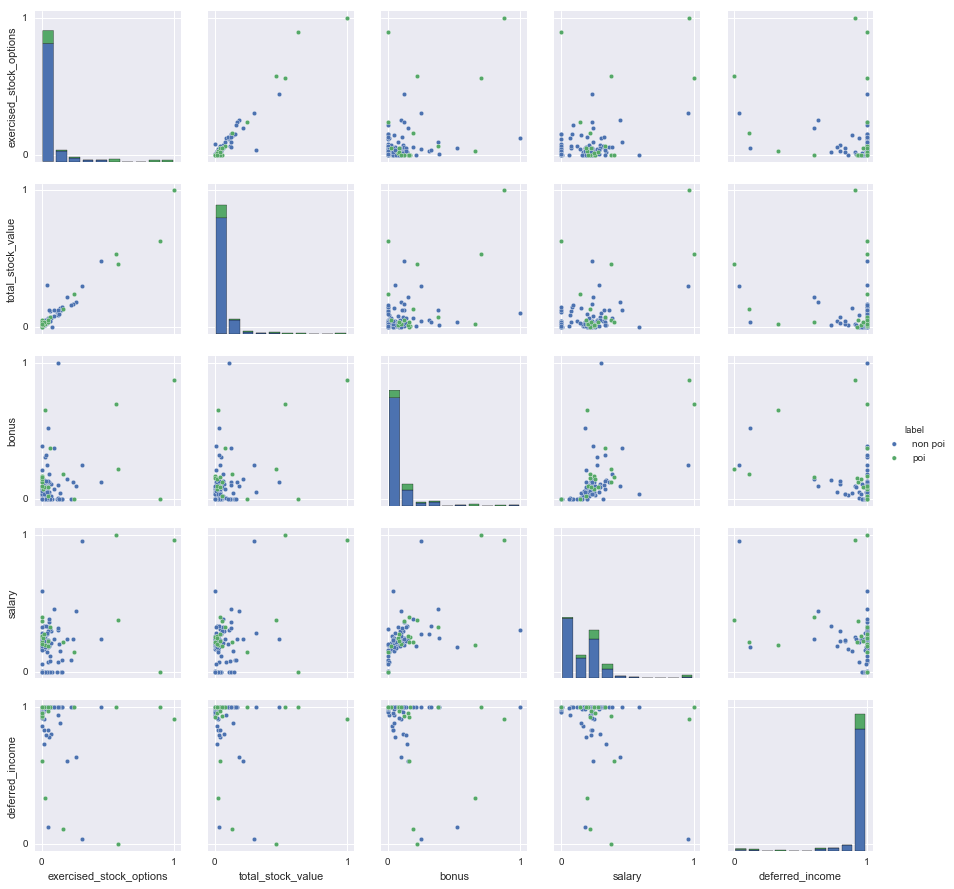

In [8]:
# create scatter matrix of the top 5 features
top_5_features = [f for (f, s) in list(score_list)[:5]]

# add 'poi' to include this feature in the plotting dataframe
plot_features = top_5_features
plot_features.append('poi')

# create dataframe copy with the desired columns for plotting
data_df_plot = data_df.loc[:, plot_features].fillna(value=0)

# scale all features except for 'poi'
scaler = MinMaxScaler()
data_df_plot[top_5_features[:-1]] = scaler.fit_transform(data_df_plot[top_5_features[:-1]])

# create 'label' feature as 'hue' input for sns.pairplot() 
data_df_plot['label'] = 0
data_df_plot.loc[data_df_plot['poi'] == True, 'label'] = 'poi'
data_df_plot.loc[data_df_plot['poi'] == False, 'label'] = 'non poi'

# remove 'poi' feature
data_df_plot.drop(['poi'], axis=1, inplace=True)

# create pairplot
fig = sns.pairplot(data_df_plot, hue="label", diag_kind="hist")  

# format axes
for i, axes in enumerate(fig.axes):
    for j, ax in enumerate(axes):
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        ax.set_xticklabels([0, 1])
        ax.set_xticks([0, 1])
        ax.set_yticklabels([0, 1])
        ax.set_yticks([0, 1])

plt.show()

<font size="5" color="red">
interpretation scatter matrix


only use 'exercised_stock_options' or 'total_stock_value', strong correlation between these two features as expected

deferred_income is negative -> most values around 1

'loan_advances' contains only 3 non zero values 

replacement with 'expenses' and 'poi_email_fraction'
</font>

In [9]:
# store top 10 features in a list
top_10_features = [f for (f, s) in list(score_list)[:10]]
top_10_features.extend(['expenses', 'poi_email_fraction'])
top_10_features = [i for i in top_10_features if i not in ['total_stock_value', 'loan_advances']]

## Algorithm Selection and Tuning


A lot of different classification algorithms could be applied to the identification of the POI labels. I focused on the following classifiers: 

* Logistic Regression
* Gaussian Naive Bayes
* Support Vector Classifier
* KNeighbors Classifier
* Decision Tree Classifier
* Random Forest Classifier
* AdaBoost Classifier

Since the dataset for this project is imbalanced, meaning that there are a lot more non-POI data points than POI ones, I used the `StratifiedShuffleSplit` method to create 100 random folds of different training and test sets with a test size of 33 %. The results in the table printed out below are the mean values of the 100 folds.


<font size="5" color="red">...expand on StratifiedShuffleSplit.... what does stratified do? keep ration between non-POI/POI constant...</font>

In [10]:
# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))
X = X.values

y = data_df['poi'].astype(int).values

# classifier names and objects    
names = ['Logistic Regression', 'Gaussian Naive Bayes', 'Support Vector Classifier', 'KNeighbors Classifier', 
         'Decision Tree Classifier', 'Random Forest Classifier', 'AdaBoost Classifier']
classifiers =[LogisticRegression(random_state=42),
              GaussianNB(),
              SVC(random_state=42),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=42),
              RandomForestClassifier(random_state=42),
              AdaBoostClassifier(random_state=42)]

print_score_table(names, classifiers, X, y, random_state=42)

Classifier                Accuracy   Precision  Recall
------------------------------------------------------
Logistic Regression       0.87       0.22       0.05
Gaussian Naive Bayes      0.84       0.38       0.34
Support Vector Classifier 0.88       0.0        0.0
KNeighbors Classifier     0.86       0.11       0.03
Decision Tree Classifier  0.81       0.28       0.3
Random Forest Classifier  0.87       0.29       0.12
AdaBoost Classifier       0.84       0.3        0.23


For the evaluation of our machine learning algorithms I used three different metrics. The 'Accuracy' stands for the number of correct predictions in relation to all predictions. As there are a lot of non-POI data points accuracy tends to be rather high for all the different models and we need to consider different scoring approaches. 

The 'Recall' score counts the number of POI data points that were actually caught by the model. 'Precision' corresponds with the fraction of POI predicitons that were correctly made.

<font size="5" color="red">...explaing recall and precision better...</font>

<font size="5" color="red">...interpret values for the different models...</font>

After just looking at the algorithm performances for the top 10 features I visualized the model performances as a function of the number of input features in the plot below.

In [11]:
# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))

y = data_df['poi'].astype(int)

# dictionary to store all results
clf_results = {} 
for n in names:
    clf_results[n] = {}
    for i in range(1, len(top_10_features) + 1):
        clf_results[n][i] = {'accuracy': [], 'precision': [], 'recall': []}

# loop trough features
for i in range(1, len(top_10_features) + 1):
    features = top_10_features[:i]
    X_i = X.loc[:, features]
    
    # training and test set split
    sss = StratifiedShuffleSplit(n_splits=100, test_size=0.33, random_state=42)
    for train_ixs, test_ixs in sss.split(X_i, y):
        X_i_train, X_i_test = X_i.iloc[train_ixs].values, X_i.iloc[test_ixs].values
        y_train, y_test = y.iloc[train_ixs].values, y.iloc[test_ixs].values

        for n, clf in zip(names, classifiers):
            clf.fit(X_i_train, y_train)
            pred = clf.predict(X_i_test)
            
            accuracy = clf.score(X_i_test, y_test)
            precision = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)
            
            clf_results[n][i]['accuracy'].append(accuracy)
            clf_results[n][i]['precision'].append(precision)
            clf_results[n][i]['recall'].append(recall)

# reformat results dictionary for easier plotting
clf_results_plot = {}
for n in names:
    clf_results_plot[n] = {"accuracy": [], 'precision': [], 'recall': []}
    
    for i in range(1, len(top_10_features) + 1):
        accuracy_cv = np.mean(clf_results[n][i]['accuracy'])
        precision_cv = np.mean(clf_results[n][i]['precision'])
        recall_cv = np.mean(clf_results[n][i]['recall'])
        
        clf_results_plot[n]['accuracy'].append(accuracy_cv)
        clf_results_plot[n]['precision'].append(precision_cv)
        clf_results_plot[n]['recall'].append(recall_cv)

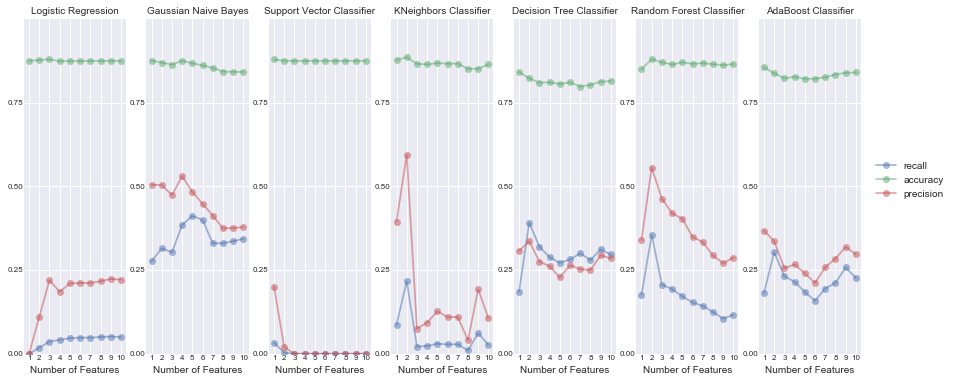

In [12]:
# visualize metrics for all algorithms
fig, axs = plt.subplots(1, len(names), figsize=(15, 6))
n_features = np.arange(1, len(top_10_features) + 1)

for ax, title in zip(axs, names):
    for m in clf_results_plot[title].keys():
        ax.plot(n_features, clf_results_plot[title][m], label=m, marker='o', alpha=0.5)
        ax.set(xlim=[0.5, 10.5], xticks=n_features, ylim=[0.0, 1.0], yticks=np.arange(0, 1, 0.25))
        ax.set_xlabel("Number of Features", fontsize=10)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8, direction='in', pad=1)

plt.legend(loc='upper right', bbox_to_anchor=(1.9, 0.6))
plt.show()

The plot above shows that 'Logistic Regression', 'Support Vector Classifier' and 'KNeighbors Classifier' in general tend to show the weakest performance independently of the number of input features. The 'Gaussian Naive Bayes', 'Decision Tree', and 'Random Forest' models show their best results with the top two to top six features, Most plots display an optimum performance for a low number of features used and only the 'AdaBoost Classifier' delivers good resuts for a low as well as a high number of input features.

<font size="5" color="red">...optimizing model parameters using gridsearchcv...</font>

In [13]:
# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))
X = X.values

y = data_df['poi'].astype(int).values
        
# parameter tuning
param_grid = {'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              'Gaussian Naive Bayes': {}, # GaussianNB has no parameters
              'Support Vector Classifier': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
              'KNeighbors Classifier': {'n_neighbors': [1, 2, 5, 10, 20],
                                        'algorithm': ['ball_tree', 'kd_tree', 'brute']},
              'Decision Tree Classifier': {'criterion': ['gini', 'entropy'], 
                                           'min_samples_split': [2, 5, 10, 20]},
              'Random Forest Classifier': {'n_estimators': [1, 2, 5, 10, 20], 
                                           'criterion': ['gini', 'entropy'], 
                                           'min_samples_split': [2, 5, 10, 20]},
              'AdaBoost Classifier': {'n_estimators': [1, 2, 5, 10, 20]}}

# optimize precision
precision_scores = find_best_parameters(names, classifiers, X, y, param_grid, score='precision', random_state=42)
print_score_parameter_table(names, precision_scores)
print()

# optimize recall
recall_scores = find_best_parameters(names, classifiers, X, y, param_grid, score='recall', random_state=42)
print_score_parameter_table(names, recall_scores)

Classifier                Precision  Parameters
------------------------------------------------
Support Vector Classifier 0.24       {'C': 100}
Logistic Regression       0.35       {'C': 10}
Gaussian Naive Bayes      0.38       {}
KNeighbors Classifier     0.31       {'algorithm': 'ball_tree', 'n_neighbors': 1}
Random Forest Classifier  0.36       {'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 20}
Decision Tree Classifier  0.3        {'min_samples_split': 5, 'criterion': 'gini'}
AdaBoost Classifier       0.34       {'n_estimators': 2}

Classifier                Recall     Parameters
------------------------------------------------
Support Vector Classifier 0.09       {'C': 1000}
Logistic Regression       0.15       {'C': 1000}
Gaussian Naive Bayes      0.34       {}
KNeighbors Classifier     0.26       {'algorithm': 'ball_tree', 'n_neighbors': 1}
Random Forest Classifier  0.27       {'min_samples_split': 2, 'criterion': 'entropy', 'n_estimators': 1}
Decision Tree Classi

Optimizing the model parameters confirmed the results from varying the number of input features. The 'Logistic Regression', 'Support Vector Classifier' and 'KNeighbors Classifier' models were dropped and not considered further for the rest of my analysis.

In a next step I tried to optimize the number of input features as well as the parameters simultaneously for the remaining four classifiers.

tune parameters and number of features together for four best algorithms
-> probably different best number of features for each algorithm

In [14]:
# select best classifiers
top_ixs = [1, 4, 5, 6]
names_top = [n for i, n in enumerate(names) if i in top_ixs]
classifiers_top = [clf for i, clf in enumerate(classifiers) if i in top_ixs]

param_grid_top = {k: v for k, v in param_grid.items() if k not in ['Logistic Regression', 'Support Vector Classifier', 
                                                                   'KNeighbors Classifier']}

# data preparation
X = data_df.loc[:, top_10_features]
scaler = MinMaxScaler()
X[top_10_features] = scaler.fit_transform(X[top_10_features].fillna(value=0))

y = data_df['poi'].astype(int).values

In [94]:
def optimize_features_and_parameters(names, classifiers, X, y, top_features, param_grid, score='accuracy', random_state=None):
    """
    """
    # perform parameter optimization for varying number of input features
    clf_scores = {}
    for i in range(1, len(top_features) + 1):
        features = top_features[:i]
        X_i = X.loc[:, features].values
        
        scores = find_best_parameters(names, classifiers, X_i, y, param_grid, score=score, random_state=random_state)
        clf_scores[i] = scores
    
    # select best results for each classifier
    clf_best_scores = {}
    for n in names:
        best_score, best_i, best_params = 0, 0, None
        
        for i, v in clf_scores.items():
            for k, v in v.items():
                if k == n:
                    if v[score] > best_score:
                        best_score = v[score]
                        best_i = i
                        best_params = v['parameters']
        
        clf_best_scores[n] = {score: best_score, 'input features': best_i, 'parameters': best_params}
            
    return clf_best_scores

In [95]:
#names_1 = names_top[:2]
#classifiers_1 = classifiers_top[:2]
#param_grid_1 = {k: v for k, v in param_grid.items() if k in ['Gaussian Naive Bayes', 'Decision Tree Classifier']}

precision_scores = optimize_features_and_parameters(names_top, classifiers_top, X, y, top_10_features, param_grid_top, 
                                                    score='precision', random_state=42)

{'Gaussian Naive Bayes': {'parameters': {}, 'input features': 4, 'precision': 0.53053571428571411}, 'Decision Tree Classifier': {'parameters': {'min_samples_split': 20, 'criterion': 'gini'}, 'input features': 1, 'precision': 0.39969047619047621}, 'Random Forest Classifier': {'parameters': {'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 10}, 'input features': 2, 'precision': 0.62024206349206346}, 'AdaBoost Classifier': {'parameters': {'n_estimators': 1}, 'input features': 1, 'precision': 0.58911904761904765}}


In [101]:
def print_classifier_table(scores):
    """
    
    """
    
    # get column names
    col_headers = ["Classifier"]
    for k in next(iter(scores.values())).keys():
        col_headers.append(k.title())
    
    # get row data
    rows = []
    for clf in scores.keys():
        row = [v for v in scores[clf].values()]
        row.insert(0, clf)
        rows.append(row)
    
    # find longest string for each column, determines column width
    cols = [list(x) for x in zip(*rows)]
    cols = [[str(x) for x in l1] for l1 in cols]
    
    col_widths = []
    for c in cols:
        col_widths.append(max(len(x) for x in c) + 2)
    
    # check if header itself is longer than longest column value, if so replace the width value
    col_widths = [w if w >= len(h) - 2 else len(h) + 2 for h, w in zip(col_headers, col_widths)] # if/else list comprehension
    
    # print out results table header
    header_str = ""
    for h, w in zip(col_headers, col_widths):
        header_str += "{col_header: <{width}}".format(col_header=h, width=w)
    
    print(header_str)
    print("-" * len(header_str))
    
    # print out table rows
    for r in rows:
        row_str = ""
        for v, w in zip(r, col_widths):
            row_str += "{val: <{width}}".format(val=str(v), width=w)
        print(row_str)

print_classifier_table(precision_scores)

Classifier                Parameters                                                         Input Features  Precision       
-----------------------------------------------------------------------------------------------------------------------------
Gaussian Naive Bayes      {}                                                                 4               0.530535714286  
Decision Tree Classifier  {'min_samples_split': 20, 'criterion': 'gini'}                     1               0.39969047619   
Random Forest Classifier  {'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 10}  2               0.620242063492  
AdaBoost Classifier       {'n_estimators': 1}                                                1               0.589119047619  


In [ ]:
recall_scores = optimize_features_and_parameters(names_top, classifiers_top, X, y, top_10_features, param_grid_top, 
                                                    score='recall', random_state=42)
print(recall_scores)

In [78]:
import math

8

top 2 optimal configurations:




cross-validation for train/test split -> stratifiedkfold -> best model


## PCA Approach

Instead of selecting the features that influence target labels the most one can use principal component analysis (PCA) to condense all...

In [ ]:
# data preparation
X = data_df.fillna(value=0).select_dtypes(include=[np.number])
y = data_df['poi'].astype(int).values

# pca
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.values)

print_score_table(names, classifiers, X_pca, y, random_state=42)

do for 2 and 3 principal components

plot decision boundaries for 2 components

show that parameter tuning and train/test crossval still deliver worse results than the models above

In [ ]:
# parameter tuning
best_parameter_search(names, classifiers, X, y, param_grid, score='precision', random_state=42)
print()
best_parameter_search(names, classifiers, X, y, param_grid, score='recall', random_state=42)

## Conclusion

best model...
